In [1]:
%load_ext autoreload
%autoreload 2

# 1.数据预处理模块
**DataPreprocess.py**   
目前的数据主要为json格式.
需要进过多部处理才可以作为输入模型的数据.

1. 读取json文件
2. 转为为NodePlan
3. 转为为dataframe (添加两个字段: sql_id, parent_id)
4. 统计各个特征的分布等.数据统计


In [2]:
# 1.数据处理
import sys, os
sys.path.append(os.path.abspath(".."))  # 确保当前目录加入路径

from models.DataPreprocessor import get_plans_dict, DataPreprocessor, plan_trees_to_graphs, graphs_to_df, df_to_graphs, DFStatisticsInfo

json_path = "../data/train_plan_*.csv"
plans_dict, execution_times = get_plans_dict(json_path)
print("plans_dict:\n", plans_dict[0:5])
print("execution_times:\n", execution_times[0:5])

preprocessor = DataPreprocessor()
plans_tree = preprocessor.preprocess_all(plans_dict)

edges_list, matrix_plans = plan_trees_to_graphs(plans_tree, add_self_loops=True, undirected=False)
print(matrix_plans[0][0])
print(matrix_plans[0][1])
print(edges_list[0])
print(edges_list[99])

plans_df = graphs_to_df(matrix_plans)
plans_df.to_csv("../data/process/01_plans_df.csv", index=False)
plans_df.head()

# stats = DFStatisticsInfo(plans_df, sample_threshold=200, sample_k=10, strict_alias_check=True)
# node_types = stats.get_node_type_set()
# global_must = stats.global_must_keys()
# global_all  = stats.global_all_keys()
# per_key     = stats.per_key_values()
# per_type    = stats.per_nodetype_key_stats()
# issues      = stats.report_issues()
# stats.pretty_print_report()


找到的文件: ['../data/train_plan_part17.csv', '../data/train_plan_part8.csv', '../data/train_plan_part6.csv', '../data/train_plan_part3.csv', '../data/train_plan_part19.csv', '../data/train_plan_part9.csv', '../data/train_plan_part11.csv', '../data/train_plan_part1.csv', '../data/train_plan_part0.csv', '../data/train_plan_part18.csv', '../data/train_plan_part10.csv', '../data/train_plan_part12.csv', '../data/train_plan_part16.csv', '../data/train_plan_part15.csv', '../data/train_plan_part2.csv', '../data/train_plan_part14.csv', '../data/train_plan_part5.csv', '../data/train_plan_part7.csv', '../data/train_plan_part13.csv', '../data/train_plan_part4.csv']
总数据行数: 100000
df:
       id                                               json
0  85000  {"Plan": {"Node Type": "Bitmap Heap Scan", "Pa...
1  85001  {"Plan": {"Node Type": "Gather", "Parallel Awa...
2  85002  {"Plan": {"Node Type": "Hash Join", "Parallel ...
3  85003  {"Plan": {"Node Type": "Gather", "Parallel Awa...
4  85004  {"Plan": {"No

,plan_id,node_idx,Node Type,Parallel Aware,Relation Name,Alias,Startup Cost,Total Cost,Plan Rows,Plan Width,...,Peak Memory Usage,Filter,Rows Removed by Filter,Join Filter,Rows Removed by Join Filter,Merge Cond,Sort Key,Sort Method,Sort Space Used,Sort Space Type
0,0,0,Bitmap Heap Scan,False,movie_keyword,mk,11788.77,49094.94,1028173,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,Bitmap Index Scan,False,NaN,NaN,0.00,11531.73,1028173,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,Gather,False,NaN,NaN,59038.23,292179.55,958880,136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,Hash Join,True,NaN,NaN,58038.23,195291.55,399533,136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2,Index Scan,True,cast_info,ci,0.44,96872.38,1832141,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from this import d
from models.DataPreprocessor import safe_cond_parse, process_predicate_list
import pandas as pd

# schema信息
db_info = pd.read_csv("../data/column_min_max_vals.csv")
db_info["table_name"], db_info["column_name"] = db_info["name"].str.split(".").str[0], db_info["name"].str.split(".").str[1]
print(db_info.head())
print("-"*100)

# 需要解析的条件列表
NEED_PARSE_COND_SCAN = [
    "Filter",
    "Index Cond",
    "Recheck Cond"
]

NEED_PARSE_COND_JOIN = [
    "Hash Cond",
    "Join Filter",
    "Merge Cond",
]

NEED_PARSE_COND_COLS = NEED_PARSE_COND_SCAN + NEED_PARSE_COND_JOIN

for col in NEED_PARSE_COND_COLS:
    plans_df[f"{col}_Split"] = plans_df[col].apply(safe_cond_parse)

# 将需要解析的条件列表统一放到predicatge_list
def merge_split_predicates(df: pd.DataFrame,
                           suffix: str = "_Split",
                           new_col: str = "predicatge_list") -> pd.DataFrame:
    df = df.copy()
    split_cols = [c for c in df.columns if c.endswith(suffix)]
    if not split_cols:
        df[new_col] = [[] for _ in range(len(df))]
        return df

    # 保证每个单元格都是 list（NaN/None/标量 → []）
    def to_list(x):
        if isinstance(x, list):
            return x
        if isinstance(x, tuple):
            return list(x)
        return []

    tmp = df[split_cols].applymap(to_list)

    # 行内拼接多个 *_Split 列（展平）
    df[new_col] = tmp.apply(lambda row: [item for sub in row for item in sub], axis=1)
    return df
plans_df = merge_split_predicates(plans_df)
print("合并predicatge_list")
# 将predicatge_list [lhs, op, rhs] 里面的col变为int， op变为int， value变为int
# 确保空值是空列表，方便按行处理
plans_df["predicatge_list"] = plans_df["predicatge_list"].apply(lambda v: v if isinstance(v, list) else [])

# 逐行调用，得到“处理后的谓词列表”
# plans_df["predicatge_list_processed"] = plans_df["predicatge_list"].apply(
#     lambda lst: process_predicate_list(lst, db_info, plans_df["Alias"])
# )
plans_df["predicate_list_processed"] = plans_df.apply(
    lambda row: process_predicate_list(
        predicate_list=row["predicatge_list"],
        db_info=db_info,
        default_alias=row.get("Alias"),
        index_name=row.get("Index Name")
    ),
    axis=1
)
print("处理谓词列表完成")

# 1：将nodetype做一个新列名叫node_type_id，
# 2：将Plan Rows 和Plan Width也做一个新列plan_rows, plan_width都是做完log1p的
import numpy as np
node_types = plans_df["Node Type"].unique()
node_types_dict = {node_type: i for i, node_type in enumerate(node_types)}
plans_df["node_type_id"] = plans_df["Node Type"].map(node_types_dict)
print("处理node_type_id完成")
plans_df["plan_rows"]  = np.log1p(pd.to_numeric(plans_df["Plan Rows"],  errors="coerce").fillna(0.0)).astype("float32")
print("处理plan_rows完成")
plans_df["plan_width"] = np.log1p(pd.to_numeric(plans_df["Plan Width"], errors="coerce").fillna(0.0)).astype("float32")
print("处理plan_width完成")

print(plans_df.head())
print("-"*100)


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
                name   min      max  cardinality  num_unique_values  \
0               t.id     1  2528312      2528312            2528312   
1

/tmp/ipykernel_24236/3845298765.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tmp = df[split_cols].applymap(to_list)


合并predicatge_list


In [ ]:
# 只保留"plan_id","node_idx","node_type_id","plan_rows","plan_width","predicate_list_processed"
plans_df = plans_df[["plan_id","node_idx","node_type_id","plan_rows","plan_width","predicate_list_processed"]]

graphs = df_to_graphs(plans_df)
print(graphs[0])
print("-"*100)

plans_df.to_csv("../data/process/02_plans_df.csv", index=False)

[{'node_type_id': 0, 'plan_rows': 13.843295097351074, 'plan_width': 2.5649492740631104, 'predicate_list_processed': [(15, 1, 0.12850956629325702, False)]}, {'node_type_id': 1, 'plan_rows': 13.843295097351074, 'plan_width': 0.0, 'predicate_list_processed': [(15, 1, 0.12850956629325702, False)]}]
----------------------------------------------------------------------------------------------------


In [ ]:
# 列的最长长度
max_len = max(len(x) for x in plans_df["predicate_list_processed"])
print(f"predicate_list_processed 列的最长长度为: {max_len}")


predicate_list_processed 列的最长长度为: 3


# 2. 数据准备
TrainAndEval.py

## 该模块主要内容
1. 将数据划分为训练集,验证集,测试集
2. 构建数据集
3. 创建数据加载器



In [ ]:
# 5. 数据准备
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
from models.TrainAndEval import build_dataset

# 构建数据集
dataset = build_dataset(graphs, edges_list, execution_times, in_dim=3+3*4, max_len=3)

print(f"数据集大小: {len(dataset)}")
for i in range(3):
    print(dataset[i].x)
    print(dataset[i].edge_index)
    print(dataset[i].y)
    print("="*100)
# 数据集划分
train_indices, temp_indices = train_test_split(
    range(len(dataset)), test_size=0.3, random_state=42
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, random_state=42
)

train_dataset = [dataset[i] for i in train_indices]
val_dataset = [dataset[i] for i in val_indices]
test_dataset = [dataset[i] for i in test_indices]

print("-"*100)
print(f"训练集: {len(train_dataset)}, 验证集: {len(val_dataset)}, 测试集: {len(test_dataset)}")


使用设备: cuda
数据集大小: 100000
tensor([[ 0.0000, 13.8433,  2.5649, 15.0000,  1.0000,  0.1285,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.0000, 13.8433,  0.0000, 15.0000,  1.0000,  0.1285,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
tensor([[0, 1, 0],
        [0, 1, 1]])
tensor([224.4540])
tensor([[ 2.0000, 13.7735,  4.9200,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 3.0000, 12.8981,  4.9200,  1.0000,  0.0000, 17.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 4.0000, 14.4210,  3.7612,  3.0000,  0.0000,  0.9000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 5.0000, 12.3447,  4.5539,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0

In [ ]:
# 创建数据加载器
batch_size = 36
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"训练批次数: {len(train_loader)}, 验证批次数: {len(val_loader)}")

for i in train_loader:
    print(i)
    print("-"*100)
    print(i.x.shape)
    print("-"*100)
    print(i.edge_index.shape)
    print("-"*100)
    print(i.y.shape)
    print("="*100)
    break


训练批次数: 1945, 验证批次数: 417
DataBatch(x=[195, 15], edge_index=[2, 354], y=[36], batch=[195], ptr=[37])
----------------------------------------------------------------------------------------------------
torch.Size([195, 15])
----------------------------------------------------------------------------------------------------
torch.Size([2, 354])
----------------------------------------------------------------------------------------------------
torch.Size([36])


# 3. 模型模块

## NodeEncoder
NodeEncoder.py
主要包括了各种vectorical的编码方式.

1. 转为为Matrix(Node, Edge)


## TreeEncoder
TreeEncoder.py
目前包括两种模型一个是GAT,一个是传统GNN.
1. 转为vector

## PredictionHead
PredictionHead.py
目前进行最简单的FNN进行后续回归任务

1. 预测






In [ ]:
# 模型搭建
import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch

from models.NodeEncoder import *
from models.TreeEncoder import *
from models.PredictionHead import *
from models.TrainAndEval import EarlyStopping

class CostModel(nn.Module):
    def __init__(self, nodecoder: nn.Module, treeencoder: nn.Module, predict_head: nn.Module):
        super().__init__()
        self.nodecoder = nodecoder
        self.treeencoder = treeencoder
        self.predict_head = predict_head

    def forward(self, data):
        x = self.nodecoder(data.x)                              # [N, d_node]
        batch_vec = getattr(data, "batch", None)
        if batch_vec is None:
            batch_vec = x.new_zeros(x.size(0), dtype=torch.long)
        g = self.treeencoder(x, data.edge_index, batch_vec)     # ✅ [B, d_graph]
        y = self.predict_head(g)                                # ✅ [B, 1] or [B]
        return y


num_node_types = int(plans_df['node_type_id'].max()) + 1
num_cols = max([p[0] for graph in graphs for node in graph 
               for p in node.get('predicate_list_processed', []) if len(p) >= 1], default=31) + 1
num_ops = max([p[1] for graph in graphs for node in graph 
              for p in node.get('predicate_list_processed', []) if len(p) >= 2], default=5) + 1
print(f"修正后的vocabulary大小: node_types={num_node_types}, cols={num_cols}, ops={num_ops}")
# 重新创建模型
f_in, d_node, d_graph, out_dim = len(dataset[0].x), 39, 64, 1
nodecoder = NodeEncoder_V1(
    num_node_types=num_node_types,
    num_cols=num_cols, 
    num_ops=num_ops,
    out_dim=d_node,
)
gatTreeEncoder = GATTreeEncoder(
    in_dim=d_node,
    hidden_dim=64,
    out_dim=d_graph
)
predict_head = PredictionHead_FNNMini(
    in_dim=d_graph,
    out_dim=out_dim
)

# 重新构建模型
model = CostModel(nodecoder, gatTreeEncoder, predict_head)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(model)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
criterion = torch.nn.MSELoss()
early_stopping = EarlyStopping(patience=15, min_delta=0.001)

修正后的vocabulary大小: node_types=13, cols=20, ops=4
CostModel(
  (nodecoder): NodeEncoder_V1(
    (type_emb): Embedding(13, 16)
    (pred_enc): PredicateEncoder1(
      (col_emb): Embedding(20, 8)
      (op_emb): Embedding(4, 3)
    )
    (num_proj): Identity()
    (proj): Linear(in_features=39, out_features=39, bias=True)
  )
  (treeencoder): GATTreeEncoder(
    (gat1): GATConv(39, 64, heads=8)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (gat2): GATConv(512, 64, heads=1)
    (proj_res): Linear(in_features=512, out_features=64, bias=True)
  )
  (predict_head): PredictionHead_FNNMini(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)


# 4 训练&评估
## 训练
主要模块为划分训练集,测试集,验证集.
调用模型进行训练.
## 评估
主要为评估方式.目前为MSE以及Q-error.


In [ ]:
from datetime import datetime
from models.TrainAndEval import train_epoch, validate_epoch
import time

#  8. 训练循环
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, 
                early_stopping, device, weight_path, num_epochs=100):
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    print("开始训练...")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # 训练
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        # 验证
        val_loss, q50, q95 = validate_epoch(model, val_loader, criterion, device)

        # 学习率调度
        scheduler.step(val_loss)
        
        # 记录损失
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # 计算时间
        epoch_time = time.time() - start_time
        
        # 打印进度
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1:3d}/{num_epochs} | "
                  f"Train Loss: {train_loss:.6f} | "
                  f"Val Loss: {val_loss:.6f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
                  f"Time: {epoch_time:.2f}s")
        
        # 早停检查
        if early_stopping(val_loss, model):
            print(f"\n早停触发在第 {epoch+1} 轮")
            break
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            date = datetime.now().strftime("%m%d")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, f'../results/weight_{date}.pth')
    
        print("-"*100)
    print("-" * 60)
    print("训练完成!")
    print(f"最佳验证损失: {best_val_loss:.6f}")
    
    return train_losses, val_losses

# 开始训练
date = datetime.now().strftime("%m%d")
weight_path = f'../results/{date}.pth'
train_losses, val_losses = train_model(
    model, train_loader, val_loader, optimizer, scheduler, 
    criterion, early_stopping, device, weight_path, num_epochs=100
)


开始训练...
------------------------------------------------------------
Median: 2.2289052616289355
Mean: 132.16552320242056
val_loss: 55331193.911571 | MedianQ: 2.229 | Q90: 129.902 | MeanQ: 132.166
Epoch   1/100 | Train Loss: 89041243.010572 | Val Loss: 55331193.911571 | LR: 1.00e-03 | Time: 20.79s
----------------------------------------------------------------------------------------------------
Median: 1.837206421978427
Mean: 119.84040182816892
val_loss: 42776263.100420 | MedianQ: 1.837 | Q90: 107.543 | MeanQ: 119.840
----------------------------------------------------------------------------------------------------
Median: 1.8512517401592086
Mean: 88.4372525899402
val_loss: 40049998.605441 | MedianQ: 1.851 | Q90: 79.154 | MeanQ: 88.437
----------------------------------------------------------------------------------------------------
Median: 1.918526038273584
Mean: 85.12497395952374
val_loss: 33393683.620354 | MedianQ: 1.919 | Q90: 78.696 | MeanQ: 85.125
---------------------------

In [ ]:
from models.TrainAndEval import evaluate_model

# 评估模型
targets, predictions, metrics = evaluate_model(model, test_loader, device)
 
# 1.4~1.5左右
#周期短 使用的mini模型 之前尝试添加层数,效果提高.


Median: 1.5511651846188004
Mean: 14.778318978110002

测试集评估结果:
MSE:  15301351.000000
Q50: 1.551, Q90: 14.581, QMean: 14.778


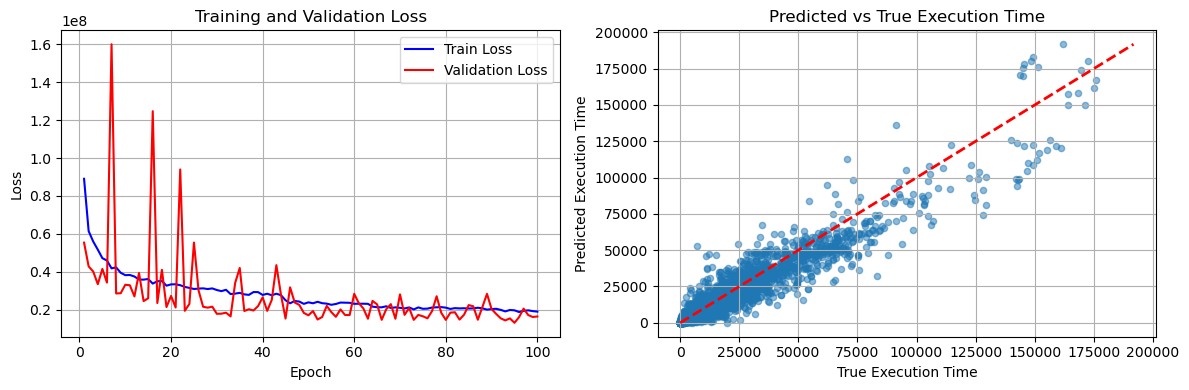

In [ ]:

# 10. 可视化训练过程和结果
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(12, 4))
    
    # 训练损失曲线
    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # 预测 vs 真实值
    plt.subplot(1, 2, 2)
    plt.scatter(targets, predictions, alpha=0.5, s=20)
    min_val = min(targets.min(), predictions.min())
    max_val = max(targets.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel('True Execution Time')
    plt.ylabel('Predicted Execution Time')
    plt.title('Predicted vs True Execution Time')
    plt.grid(True)
    
    plt.tight_layout()
    date = datetime.now().strftime("%m%d")
    plt.savefig(f'../results/training_results_{date}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 创建结果目录
os.makedirs('../results', exist_ok=True)
# 绘制结果
plot_training_history(train_losses, val_losses)


# 验证其他数据集

In [ ]:
from platform import node


job_path = "../data/job_light_plans.csv"
job_dict, job_execution_times = get_plans_dict(job_path)

job_tree = preprocessor.preprocess_all(job_dict)
job_edges_list, job_matrix_plans = plan_trees_to_graphs(job_tree, add_self_loops=True, undirected=False)
job_plans_df = graphs_to_df(job_matrix_plans)
job_plans_df.to_csv("../data/process/03_job_plans_df.csv", index=False)

job_plans_df = merge_split_predicates(job_plans_df)
job_plans_df["predicate_list_processed"] = job_plans_df.apply(
    lambda row: process_predicate_list(
        predicate_list=row["predicatge_list"],
        db_info=db_info,
        default_alias=row.get("Alias"),
        index_name=row.get("Index Name")
    ),
    axis=1
)

node_types = job_plans_df["Node Type"].unique()
node_types_dict = {node_type: i for i, node_type in enumerate(node_types)}
job_plans_df["node_type_id"] = job_plans_df["Node Type"].map(node_types_dict)

job_plans_df["plan_rows"]  = np.log1p(pd.to_numeric(job_plans_df["Plan Rows"],  errors="coerce").fillna(0.0)).astype("float32")
job_plans_df["plan_width"] = np.log1p(pd.to_numeric(job_plans_df["Plan Width"], errors="coerce").fillna(0.0)).astype("float32")

job_plans_df = job_plans_df[["plan_id","node_idx","node_type_id","plan_rows","plan_width","predicate_list_processed"]]

job_graphs = df_to_graphs(job_plans_df)

job_dataset = build_dataset(job_graphs, job_edges_list, job_execution_times, in_dim=3+3*4, max_len=3)

job_data_loader = DataLoader(job_dataset, batch_size=36, shuffle=False)

targets, predictions, metrics = evaluate_model(model, job_data_loader, device)

